## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from time import time
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
from tdcalendar import *

## Data preparation

### Price data collection

In [2]:
def getYahooData(symbolList, adjust=True, startStr='1990-01-01', endStr='2046-12-31'):
    """Scrape via yahoo API to obtain data for a symbolList."""
    symbolStr = ' '.join(symbolList)
    renameDict = {'Date': 'date', 'Open': 'op', 'High': 'hi', 'Low': 'lo', 'Close': 'cl',
                  'Volume': 'vol', 'Adj Close': 'adj_cl', 'Dividends': 'div', 'Stock Splits': 'split'}
    priceFields = ['op', 'hi', 'lo', 'cl']
    dataFields = priceFields + ['vol', 'div']

    dataDict = {}

    try:
        dfData = yf.download(symbolStr, start=startStr, end=endStr, auto_adjust=False, actions=True,
                             group_by='Tickers', threads=16)
    except:
        dfData = pd.DataFrame()

    for symbol in symbolList:
        try:
            dfSymbol = dfData[(symbol,)].dropna()  # Raw data for the symbol
            dfSymbol = dfSymbol[(dfSymbol['Volume'] > 0) | (dfSymbol['High'] > dfSymbol['Low'])]  # Filter bad data
            dfSymbol.reset_index(inplace=True)
            dfSymbol.rename(columns=renameDict, inplace=True)
            dfSymbol.set_index('date', inplace=True)

            if not adjust:
                dfSymbol = dfSymbol[dataFields]
                dfSymbol.rename(columns={field: f'{symbol}_{field}' for field in dataFields}, inplace=True)
            else:
                adjfactor = dfSymbol['adj_cl'] / dfSymbol['cl']
                for field in priceFields:
                    dfSymbol[f'adj_{field}'] = dfSymbol[field] * adjfactor
                dfSymbol['adj_vol'] = dfSymbol['vol'] / adjfactor
                dfSymbol = dfSymbol[[f'adj_{field}' for field in dataFields[:-1]]]
                dfSymbol.rename(columns={f'adj_{field}': f'{symbol}_{field}' for field in dataFields[:-1]}, inplace=True)
                dfSymbol = np.round(dfSymbol, 4)

            dataDict[symbol] = dfSymbol
        except:
            print(f'Failed preparing data for {symbol}.')

    dfAll = pd.concat(dataDict.values(), axis=1, join='inner')
    dfAll.fillna(method='ffill', inplace=True)

    return dfAll

In [3]:
symbolList = ['SPY', 'QQQ', 'IWM', 'EWH', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'BRK-B', 'BA']

startStr = '2011-01-01'
endStr = '2023-01-01'
dfAll = getYahooData(symbolList, True, startStr, endStr)

[*********************100%***********************]  10 of 10 completed


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-p

### Dictionary of dataframes of open, close & log-change columns in training period

In [4]:
startStr_train1 = '2019-07-01'
endStr_train1 = '2022-07-01'
startDate_train1 = datetime.strptime(startStr_train1, '%Y-%m-%d')
endDate_train1 = datetime.strptime(endStr_train1, '%Y-%m-%d')

startStr_test1 = getLatestTradingDay(holidayList_ny, endDate_train1, days=0, offset=0)
endStr_test1 = '2022-12-31'
startDate_test1 = datetime.strptime(startStr_test1, '%Y-%m-%d')
endDate_test1 = datetime.strptime(endStr_test1, '%Y-%m-%d')
tradeDateList_test1 = getTradingDays(holidayList_ny, startDate_test1, endDate_test1)

dataDict_train1 = {}
dataDict_test1 = {}

for symbol in symbolList:
    dfSymbol = dfAll[[f'{symbol}_op', f'{symbol}_cl']]
    dfSymbol[f'{symbol}_pct'] = np.log(dfSymbol[f'{symbol}_cl'] / dfSymbol[f'{symbol}_cl'].shift(1))
    dataDict_train1[symbol] = dfSymbol.loc[startStr_train1:endStr_train1]
    dataDict_test1[symbol] = dfSymbol.loc[startStr_test1:endStr_test1]
    
print(dataDict_train1['NVDA'].tail(10), '\n')

<ipython-input-4-e97c67633ca6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSymbol[f'{symbol}_pct'] = np.log(dfSymbol[f'{symbol}_cl'] / dfSymbol[f'{symbol}_cl'].shift(1))


             NVDA_op   NVDA_cl  NVDA_pct
date                                    
2022-06-17  156.3669  158.6853  0.017726
2022-06-21  164.6310  165.5403  0.042292
2022-06-22  162.1428  163.4818 -0.012513
2022-06-23  165.0706  162.1328 -0.008286
2022-06-24  164.8808  171.1363  0.054045
2022-06-27  172.9949  168.5681 -0.015120
2022-06-28  168.8779  159.7045 -0.054015
2022-06-29  158.0257  155.3077 -0.027917
2022-06-30  153.4990  151.4805 -0.024951
2022-07-01  148.8824  145.1251 -0.042861 



## Monte-Carlo Resampling (MCR)

### Construction of (1x leverage) forward time series by MCR

In [5]:
def getSim_mcr1x(dfData, dateList, startPrice=1.00, numSim=100, numDigit=4):
    """Obtain the dataframe of MCR simulations of forward price time-series."""
    # Build MCR dataframe by dummy zero-return price time-series
    dfSim = pd.DataFrame()
    for date in dateList:
        dfSim.loc[date, f'pct-0'] = 0
        dfSim.loc[date, f'cl-0'] = startPrice
    # Historical return array     
    pctArray = np.array(dfData[f'{symbol}_pct'])
    numData = len(pctArray)
    # MCR simulations
    lenPeriod = len(dateList) - 1
    for num in range(numSim):
        ordinalArray = np.random.randint(numData, size=lenPeriod)
        fwdPctArray = [0] + [pctArray[n] for n in ordinalArray]
        dfSim[f'pct-{num + 1}'] = fwdPctArray
        dfSim[f'cl-{num + 1}'] = np.round(startPrice * np.exp(dfSim[f'pct-{num + 1}'].cumsum()), numDigit)
    
    return dfSim        

def fitActualvsMCR(dfSim, dfData, dateList):
    """Fit the actual price time-series into an MCR dataframe."""
    dfSim['cl-0'] = dfData.loc[dateList, f'{symbol}_cl']
    dfSim['pct-0'] = dfData.loc[dateList, f'{symbol}_pct']
    
    return dfSim

### MCR using real stock price as starting price and its normalized copy (`startPrice = 1.00`)

In [6]:
numSim = 400

# Empty dict of MCR using real stock price as starting price
fwdDict = {}  
# `fwdDict` with each stock price normalized 
normDict = {}

# Construction of `fwdDict`
for symbol in symbolList:
    dfData_train = dataDict_train1[symbol]
    dfData_test = dataDict_test1[symbol]
    startPrice = dfData_train[f'{symbol}_cl'].iloc[-1]
    # MCR simulations (using last price in training period as )
    dfSim = getSim_mcr1x(dfData_train, tradeDateList_test1, startPrice, numSim) 
    # Concat with actual price data set (Do NOT do this with genuine future timestamps where no price data is available)
    dfSim =  fitActualvsMCR(dfSim, dfData_test, tradeDateList_test1)
    print(f'{symbol} MCR done.')
    # Normalize the MCR dataframe
    dfNorm = dfSim.copy()
    for n in range(numSim + 1):
        dfNorm[f'cl-{n}'] /= (startPrice / 100)
    # Save to dict
    fwdDict[symbol] = dfSim
    normDict[symbol] = np.round(dfNorm, 6)
    
fwdDict['NVDA'].iloc[-5:, :12]

SPY MCR done.
QQQ MCR done.
IWM MCR done.
EWH MCR done.
AAPL MCR done.
MSFT MCR done.
NVDA MCR done.
TSLA MCR done.
BRK-B MCR done.
BA MCR done.


pct-0      cl-0     pct-1      cl-1     pct-2      cl-2  \
2022-12-23 -0.008709  152.0342  0.017076  141.9673  0.005335  207.8666   
2022-12-27 -0.074027  141.1860  0.003723  142.4969 -0.041522  199.4124   
2022-12-28 -0.006037  140.3362  0.003634  143.0156 -0.021113  195.2463   
2022-12-29  0.039601  146.0052  0.023341  146.3931  0.051534  205.5718   
2022-12-30  0.000753  146.1152  0.046461  153.3551 -0.017035  202.0995   

               pct-3      cl-3     pct-4      cl-4     pct-5      cl-5  
2022-12-23  0.027902  131.5226 -0.019394  146.6565 -0.020379  342.0718  
2022-12-27  0.014090  133.3889 -0.006082  145.7672  0.000000  342.0718  
2022-12-28  0.003480  133.8538  0.019089  148.5765 -0.039278  328.8964  
2022-12-29  0.019176  136.4454 -0.053392  140.8518 -0.004746  327.3391  
2022-12-30 -0.004441  135.8407 -0.063050  132.2452  0.093628  359.4677

In [7]:
normDict['NVDA'].iloc[-5:, :12]

pct-0        cl-0     pct-1        cl-1     pct-2        cl-2  \
2022-12-23 -0.008709  104.760789  0.017076   97.824084  0.005335  143.232701   
2022-12-27 -0.074027   97.285721  0.003723   98.189011 -0.041522  137.407244   
2022-12-28 -0.006037   96.700157  0.003634   98.546426 -0.021113  134.536548   
2022-12-29  0.039601  100.606442  0.023341  100.873729  0.051534  141.651444   
2022-12-30  0.000753  100.682239  0.046461  105.670969 -0.017035  139.258819   

               pct-3       cl-3     pct-4        cl-4     pct-5        cl-5  
2022-12-23  0.027902  90.627052 -0.019394  101.055228 -0.020379  235.708227  
2022-12-27  0.014090  91.913046 -0.006082  100.442446  0.000000  235.708227  
2022-12-28  0.003480  92.233390  0.019089  102.378224 -0.039278  226.629577  
2022-12-29  0.019176  94.019160 -0.053392   97.055437 -0.004746  225.556503  
2022-12-30 -0.004441  93.602485 -0.063050   91.124967  0.093628  247.695058

### Compute percentile of final price of each MCR time series

In [8]:
def getRank_finalPrice(dfSim):
    """Obtain the percentage rank of final price of each MCR time series. """
    numSim = dfSim.shape[1] // 2 - 1
    dfRank = dfSim[[f'cl-{n + 1}' for n in range(numSim)]]
    dfRank.loc['rank'] = np.round(dfRank.iloc[-1].rank(pct=True), 4)
    dfRank = dfRank.transpose()
    
    return dfRank

rankDict = {symbol: getRank_finalPrice(dfSim) for symbol, dfSim in normDict.items()}
rankDict['NVDA'].iloc[:10, -2:]

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


2022-12-30    rank
cl-1   105.670969  0.3350
cl-2   139.258819  0.6225
cl-3    93.602485  0.2125
cl-4    91.124967  0.1900
cl-5   247.695058  0.9675
cl-6   261.901008  0.9725
cl-7    81.220271  0.1225
cl-8    82.275981  0.1300
cl-9   168.233131  0.7975
cl-10  126.744099  0.5200

### Descriptive Statistics of the simulated log-return groups

In [9]:
dfStat_mcr = pd.DataFrame()
numSim = 400

for symbol, df in fwdDict.items():
    dfPrice_mcr = np.log(df[[f'cl-{n + 1}' for n in range(numSim)]] / df['cl-0'].iloc[0])
    dfFinal_mcr = dfPrice_mcr.iloc[[-1]].transpose()
    dfStat_mcr[symbol] = dfFinal_mcr.describe().iloc[:, 0]
    
dfStat_mcr

SPY         QQQ         IWM         EWH        AAPL        MSFT  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.048448    0.059118    0.014811   -0.012019    0.171546    0.134501   
std      0.165879    0.203823    0.212226    0.154135    0.247594    0.218037   
min     -0.425962   -0.640276   -0.615177   -0.424743   -0.692573   -0.640935   
25%     -0.063496   -0.075053   -0.118924   -0.123424   -0.002527   -0.008352   
50%      0.055539    0.054945    0.015270   -0.004519    0.181779    0.129669   
75%      0.164815    0.188067    0.156500    0.102729    0.345222    0.285297   
max      0.526282    0.567314    0.743304    0.468025    0.774839    0.941091   

             NVDA        TSLA       BRK-B          BA  
count  400.000000  400.000000  400.000000  400.000000  
mean     0.219468    0.411524    0.059221   -0.201377  
std      0.369064    0.503411    0.170653    0.414635  
min     -0.775835   -1.352696   -0.503391   -1.792041  
25%     -0.016018    0.055542   -0.054145   -0.471975  
50%      0.206902    0.396827    0.046530   -0.179644  
75%      0.472322    0.770283    0.163035    0.078796  
max      1.223095    1.644878    0.556253    0.857948

### Visualize the simulated equity curves, the actual curve

In [10]:
pctileDict = {0.95: '#09752d', 0.50: '#115bef', 0.05:'#ef1139'}


def plotMCRcurves(dfSim, plotPctiles, titletext, actual=True, boldWidth=4):
    """Plot all the simulated equity curve from the same MCR together with the actual price curve (`actual` = True)."""
    # Forward price dataframe
    dfPrice = dfSim[[f'cl-{n}' for n in range(numSim + 1)]] if actual else dfSim[[f'cl-{n + 1}' for n in range(numSim)]]
    startDT = dfPrice.index[0]
    endDT = dfPrice.index[-1]
    # Plot figure & append title
    fig, ax = plt.subplots(figsize=(12, 9))
    title = f'MCR from {startDT} to {endDT} {titletext} \n'
    # Plot the resultant MCR curves
    plt.semilogy(dfPrice, linewidth=1)
    
    # For the chosen percentile, find out the corresponding final price level and bolden the curve
    for pctile, color in plotPctiles.items():
        dfRank = getRank_finalPrice(dfSim)
        rankLevel = 0
        while rankLevel / numSim < pctile:
            rankLevel += 1
        seriesName = dfRank[dfRank['rank'] == pctile].index[0] 
        finalPrice = round(dfPrice[seriesName].iloc[-1], 4)
        title += f'{round(100 * pctile, 2)}%ile = {finalPrice}, '
        plt.semilogy(dfPrice.index, dfPrice[seriesName], linewidth=boldWidth, color=color)
        
    # Bolden the special percentile equity curve
    if actual:
        plt.semilogy(dfPrice.index, dfPrice['cl-0'], color='black', linewidth=boldWidth)
        dfRank.sort_values('rank', inplace=True)
        finalPriceArray = np.array(dfRank.iloc[:, -2])
        lastPrice = dfPrice.loc[endDT, 'cl-0']
        rankActual = 0
        while lastPrice >= finalPriceArray[rankActual]:
            rankActual += 1
        pctileActual = round(100 * rankActual / numSim, 2)
        title += f'\nActual final price {lastPrice} = {pctileActual}%ile'    
            
    fig.suptitle(title, fontsize=12)   
    ax.tick_params(labelbottom=False)  

### MCR curve of normed price (w/o actual price curve)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

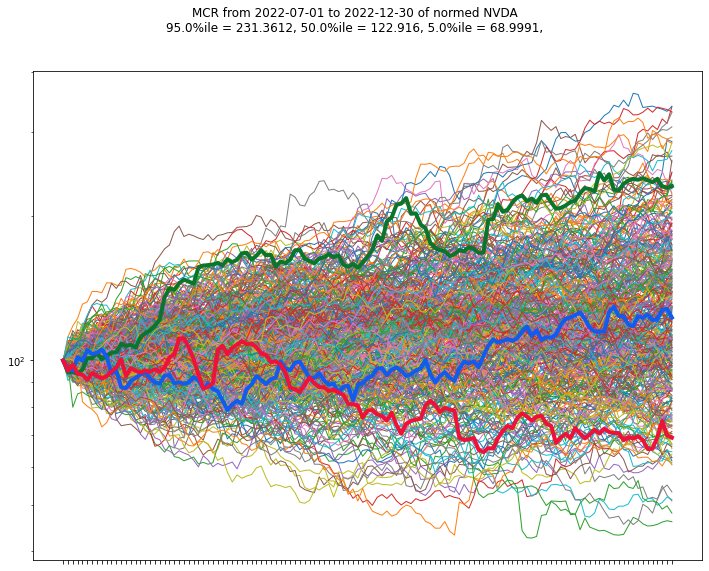

In [11]:
symbol1 = 'NVDA'
plotMCRcurves(normDict[symbol1], pctileDict, actual=False, titletext=f'of normed {symbol1}')

### MCR curve chart together with actual price curve

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

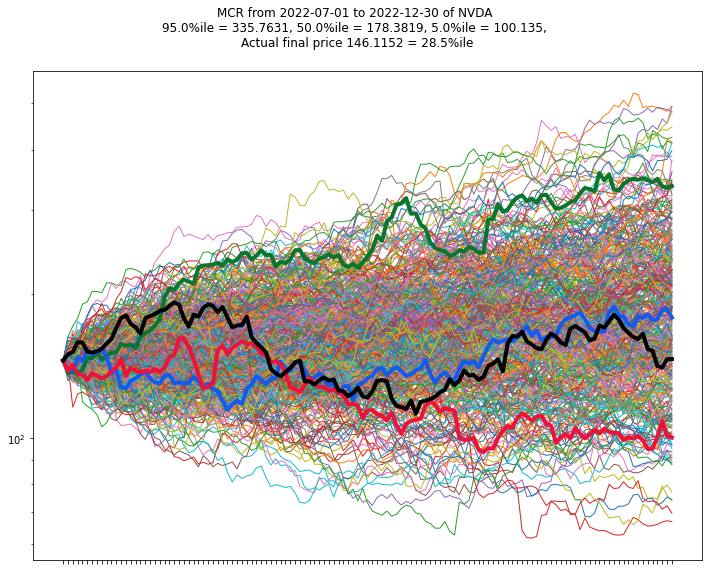

In [12]:
plotMCRcurves(fwdDict[symbol1], pctileDict, titletext=f'of {symbol1}')

### MCR curve chart with actual price being normed

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

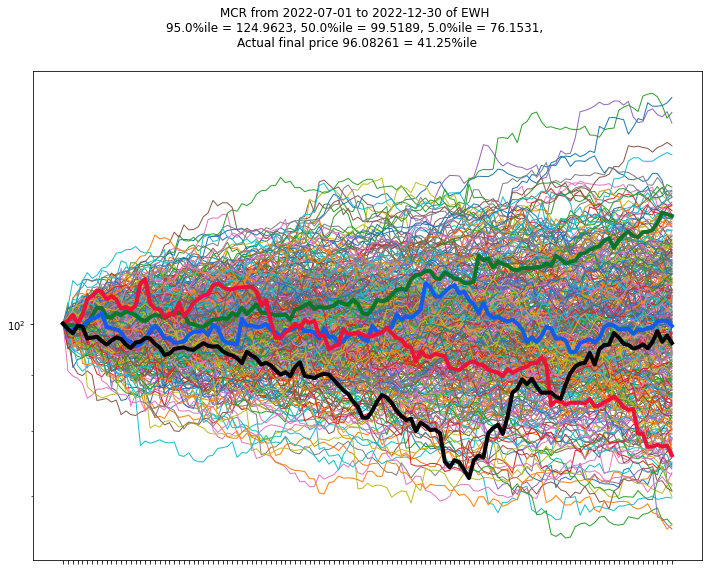

In [13]:
symbol2 = 'EWH'
plotMCRcurves(normDict[symbol2], pctileDict, titletext=f'of {symbol2}')

### An example of actual final price outside the MCR confidence interval

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

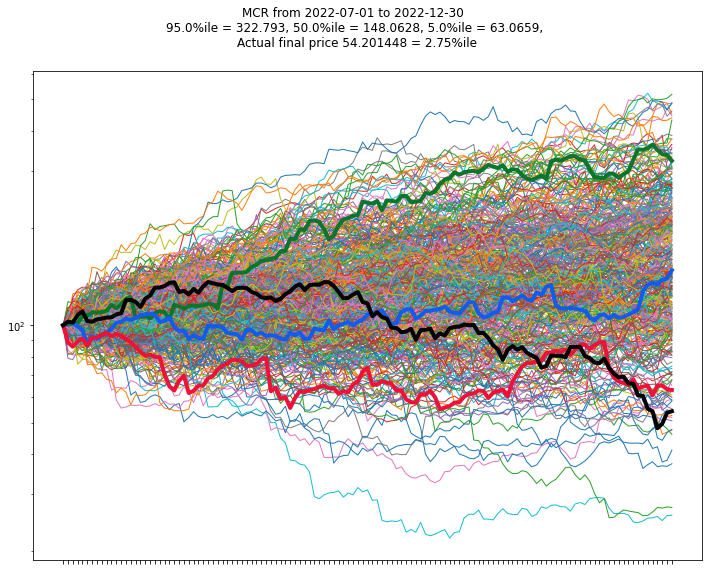

In [14]:
symbol3 = 'TSLA'
plotMCRcurves(normDict[symbol3], pctileDict, titletext='')

### Compute expected percentage return drawn from the middle 90% MCR curves

In [15]:
# Dataframe of key statistics
dfExpNAV = pd.DataFrame()

# Dataframe of mid 90% MCR final price
dfFinal = pd.DataFrame()

# Percentile levels
maxPctile = 0.95
midPctile = 0.50
minPctile = 0.05

for (symbol, dfRank), (symbol, dfNorm) in zip(rankDict.items(), normDict.items()):
    # For each symbol, extract the mid 90% final price column
    dfMid = dfRank[(dfRank['rank'] >= minPctile) & (dfRank['rank'] <= maxPctile)]
    dfFinal0 = dfMid.iloc[:, -2:]
    dfFinal0.sort_values('rank', inplace=True)
    dfFinal0.reset_index(inplace=True)
    dfFinal0.drop(['index', 'rank'], axis=1, inplace=True)
    dfFinal0.rename(columns={dfFinal0.columns[0]: symbol}, inplace=True)
    dfFinal = pd.concat([dfFinal, dfFinal0], axis=1)
    # Record the percentile level final price
    dfExpNAV.loc[symbol, f'{round(100*maxPctile, 1)}%ile'] = dfFinal[symbol].max()
    dfExpNAV.loc[symbol, f'{round(100*midPctile, 1)}%ile'] = dfFinal[symbol].median()
    dfExpNAV.loc[symbol, f'{round(100*minPctile, 1)}%ile'] = dfFinal[symbol].min()
    # Average P/L of final prices
    dfExpNAV.loc[symbol, 'avg%PL'] = round(dfFinal[symbol].mean() - 1, 4)
    dfExpNAV.loc[symbol, 'real%PL'] = round(dfNorm['cl-0'].iloc[-1] - 1, 4)

<ipython-input-15-8e3f8d27cf65>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFinal0.sort_values('rank', inplace=True)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-15-8e3f8d27cf65>:16: SettingWithCopyWarning: 
A v

In [16]:
dfExpNAV

95.0%ile    50.0%ile    5.0%ile    avg%PL   real%PL
SPY    139.085661  105.426872  79.371057  104.7300  100.1867
QQQ    150.709251  105.565698  77.351591  106.5661   93.7780
IWM    142.423593  101.484406  69.095530  101.8001  101.7190
EWH    124.962271   99.518901  76.153129   98.5395   95.0826
AAPL   174.491093  119.840285  79.598601  120.2319   92.8071
MSFT   160.596941  113.750728  80.406968  114.9454   91.8447
NVDA   231.361150  122.915953  68.999091  128.3241   99.6822
TSLA   322.793033  148.062842  63.065880  162.7685   53.2014
BRK-B  141.995351  104.741586  80.016324  105.7969  110.3153
BA     153.093035   83.490346  39.375715   85.3757  135.2200

In [17]:
dfFinal

SPY         QQQ         IWM         EWH        AAPL        MSFT  \
0     79.371057   77.351591   69.095530   76.153129   79.598601   80.406968   
1     80.048068   77.573729   69.227964   76.617764   80.489658   81.005205   
2     80.718386   77.637726   69.431211   76.699167   80.888223   81.052904   
3     81.021248   78.368066   70.127609   76.771423   81.627432   81.312086   
4     81.034077   78.526029   70.611512   77.190327   81.755563   81.336731   
..          ...         ...         ...         ...         ...         ...   
356  132.777665  147.692607  140.371864  124.381477  173.395620  158.168285   
357  132.941991  148.016008  140.493105  124.641691  173.493887  159.297849   
358  135.242687  149.635257  140.906255  124.654039  173.925858  159.553460   
359  138.511357  149.933885  141.186558  124.739100  174.284291  160.224624   
360  139.085661  150.709251  142.423593  124.962271  174.491093  160.596941   

           NVDA        TSLA       BRK-B          BA  
0     68.999091   63.065880   80.016324   39.375715  
1     69.181417   63.529659   80.375351   39.664903  
2     69.313647   63.738932   81.242739   41.214173  
3     69.533113   63.765509   81.531171   41.818864  
4     69.572390   65.130006   81.796901   41.890518  
..          ...         ...         ...         ...  
356  222.415213  317.339403  139.163387  149.477689  
357  223.905720  321.844706  139.341694  149.515804  
358  228.366974  322.575400  140.862054  150.185712  
359  228.728593  322.738471  141.098667  150.302059  
360  231.361150  322.793033  141.995351  153.093035  

[361 rows x 10 columns]

### Visualize by box plot

In [18]:
fig = make_subplots(rows=1, cols=1, specs=[[{"type": "box"}]])

for symbol in symbolList:
    fig.add_trace(go.Box(y=dfFinal[symbol], name=symbol), row=1, col=1)
    
fig.update_yaxes(type="log")
fig.show()

### Are overnight returns auto-correlated?

In [19]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    """Compute p-value of correlation coefficients."""
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 5)
    return np.round(pvalues, 4)


for symbol, df in dataDict_train1.items():
    pctArray0 = df[f'{symbol}_pct'].iloc[1:]
    pctArray1 = df[f'{symbol}_pct'].shift(1).iloc[1:]
    dfPct = pd.concat([pctArray0, pctArray1], axis=1)
    dfPct.columns = [f'{symbol}_pct0', f'{symbol}_pct1']
    corr = dfPct.corr().iloc[0, 1]    
    print(f'{symbol} auto-corr coef: {round(corr, 4)}')
    pvalue = calculate_pvalues(dfPct).iloc[0, 1]
    print(f'{symbol} auto-corr p-value: {round(pvalue, 4)}\n')

SPY auto-corr coef: -0.2139
SPY auto-corr p-value: 0.0

QQQ auto-corr coef: -0.2115
QQQ auto-corr p-value: 0.0

IWM auto-corr coef: -0.1098
IWM auto-corr p-value: 0.0025

EWH auto-corr coef: -0.1245
EWH auto-corr p-value: 0.0006

AAPL auto-corr coef: -0.1625
AAPL auto-corr p-value: 0.0

MSFT auto-corr coef: -0.2827
MSFT auto-corr p-value: 0.0

NVDA auto-corr coef: -0.1528
NVDA auto-corr p-value: 0.0

TSLA auto-corr coef: -0.0109
TSLA auto-corr p-value: 0.7654

BRK-B auto-corr coef: -0.2184
BRK-B auto-corr p-value: 0.0

BA auto-corr coef: 0.0783
BA auto-corr p-value: 0.0312

